# Predicting a grocery store chain's customer satisfaction index
**Given survey responses and transaction data from a Swedish chain of grocery stores, we'd like to predict customers' satisfaction, called the _Customer Satisfaction Index (CSI)_.**

This was my contribution to [Nepa](http://nepa.com/)'s first machine learning Modelathon (a data science hackathon) that was held the 29th of September, 2016 in Stockholm, Sweden.

## Load and clean data
Our data is roughly 150000 samples of 33 features, where each sample is a customer's information such as their age, how close they are to their grocery store, how many times they've visited recently, how much they like to buy of certain product groups, and so on.

In [1]:
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.xkcd();

In [2]:
# Load data.
df = pd.read_csv(os.path.join('Data', 'ModelathonData.csv'), encoding='latin_1')
test = pd.read_csv(os.path.join('Data', 'FinalTestLabels.csv'), encoding='latin_1')
test.index = df[df['CSI'] == 0].index
df.update(test)

# DistanceToStore contains junk after a tab character. Strip that out.
df['DistanceToStore'] = df['DistanceToStore'].str.split('\t').apply(lambda x: x[0]).astype('float')

# InterviewDate is a string, let's parse it to datetime.
from datetime import datetime
df['InterviewDate'] = df['InterviewDate'].apply(lambda s: datetime.strptime(s, '%m/%d/%Y %H:%M').timestamp())

# Feature selection. Note: we want to predict CSI so it cannot be a feature.
labels =  df['CSI']
features = df[[x for x in df.columns 
                 if x.startswith('ShareBoughtAt') or x.endswith('Id')] + [
        'Gender', 
        'CSIaverage', 
        'InterviewDate', 
        'BirthYear', 
        'PurchasingPower', 
        'VisitsLast3Months', 
        'AmountLast3Months',
        'StoreSquaremeters',
        'DistanceToStore']]

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# Split out test data.
X_test, y_test = features.iloc[test.index], labels.iloc[test.index]

# Whatever remains is our training data.
X_train, y_train = map(lambda x: x.iloc[~x.index.isin(test.index)], 
                       [features, labels])

# Normalize training data and split into test and validation sets.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1)

## Train models
Let's try out some different models and see what performs best. For performance reasons we'll train every model in its own process.

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

classifiers = [RandomForestClassifier(),
               AdaBoostClassifier()]

# Also try XGBoost if it's installed.
try:
    from xgboost.sklearn import XGBClassifier
    classifiers.append(XGBClassifier())
except:
    pass

def train(clf):
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    print(clf, score)
    return clf

from multiprocessing import Pool
with Pool(len(classifiers)) as p:
    classifiers = p.map(train, classifiers)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0.21704
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 0.24608
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 0.26752


## Test models
Let's see how well the trained models perform on unseen customer data.

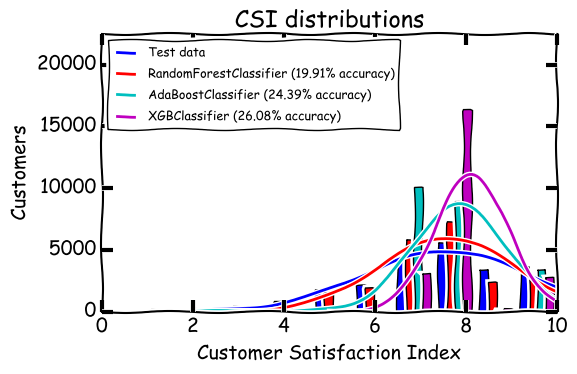

In [5]:
import matplotlib.mlab as mlab

X = scaler.transform(X_test)
predictions = [y_test]
labels = ['Test data']
for i, clf in enumerate(classifiers):
    predictions.append(clf.predict(X))
    labels.append('{} ({:0.2f}% accuracy)'.format(type(clf).__name__, 
                                                  100*clf.score(X, y_test)))
colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']][:len(predictions)]
plt.figure()
plt.hist(predictions, color=colors)
for i, p in enumerate(predictions):
    x = np.linspace(p.min(), p.max(), 100)
    plt.plot(x, y_test.size * mlab.normpdf(x, np.mean(p), np.std(p)), color=colors[i])
plt.title('CSI distributions')
plt.xlim([0, 10])
plt.ylim([0, y_test.size])
plt.legend(labels, loc='upper left', prop={'size': 9})
plt.xlabel('Customer Satisfaction Index')
plt.ylabel('Customers')
plt.tight_layout()

## Conclusions
Unfortunately our classes are imbalanced, and we have a lot of high CSI scores, and very few low ones, meaning almost every customer that got asked how satisfied they were actually seemed pretty content. That's good news for the grocery stores, but it's a problem for us, as we need our model to be familiar with not only the happy customers, but also (and maybe even especially!) the unhappy ones.

Due to this, the more complex models suffer from overfitting. Even though the random forest got the lowest accuracy (when we require each sample to be labeled with the exact CSI), its distribution is smoothest and closer to the actual test data's. Assuming we're okay with guessing CSI +- a few points, a random forest is likely our best choice for doing predictions, at least as far as classifiers go. To be absolutely sure this is the case though we should also not rely too heavily on histograms and also plot confusion matrices first.

Future experiments should look into applying ordinal regression instead of standard classification. As CSI is ordinal we'd like our model to take into account that guessing CSI = 6, when the real label should have been seven, would be a lot better than just guessing CSI = 1, even though both guesses are equally wrong in a classification sense. Whether this delimitation makes sense depends on the user of the prediction system, of course, but it seems intuitive enough.